### Predict Denemesi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score  # R² skoru için eklendi

# Verileri oku
df = pd.read_csv(r"C:\Users\ASUS\Desktop\Bitirme\4-exploratory_data_analysis\df_cleaned.csv")
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

df_dict = pd.read_csv(r"C:\Users\ASUS\Desktop\Bitirme\1-data_cleaning\clean_data.csv")

# İlçe ve mahalle encoding sözlüklerini oluştur
district_encoding_dict = df_dict.groupby('district')['price'].mean().to_dict()
neighbor_encoding_dict = df_dict.groupby('neighbor')['price'].mean().to_dict()

# X ve y verilerini hazırla
x = df[["m2", "total_room", "age", "floor", "district_encoded", "neighbor_encoded"]]
y = df["price"]

# Train/Test ayır
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Kullanıcıdan alınan ilçe ve mahalle
ilce_adi = "Kartal"
mahalle_adi = "Karlıktepe Mah."

# Sözlükten encoding değerlerini al
district_encoded = district_encoding_dict.get(ilce_adi)
neighbor_encoded = neighbor_encoding_dict.get(mahalle_adi)

# Kontrol et
if district_encoded is None or neighbor_encoded is None:
    print("Girilen ilçe veya mahalle isimleri encoding sözlüğünde bulunamadı.")
else:
    # Yeni veri oluştur
    new_data = pd.DataFrame([{
        "m2": 40,
        "total_room": 4,
        "age": 15,
        "floor": 8,
        "district_encoded": district_encoded,
        "neighbor_encoded": neighbor_encoded
    }])

    # Modeli eğit ve tahmin yap
    best_model = RandomForestRegressor(n_estimators=70)
    best_model.fit(x_train, y_train)

    predicted_price = best_model.predict(new_data)

    # Test verisi üzerinde R² skorunu hesapla
    y_pred_test = best_model.predict(x_test)
    r2 = r2_score(y_test, y_pred_test)

    # Sonuçları yazdır
    print(f"{ilce_adi}, {mahalle_adi} için tahmin edilen konut fiyatı: {predicted_price[0]:,.0f} TL")
    print(f"Modelin test verisi üzerindeki R² skoru: {r2:.4f}")
    


Kartal, Karlıktepe Mah. için tahmin edilen konut fiyatı: 4,608,457 TL
Modelin test verisi üzerindeki R² skoru: 0.9128


## Optimum test size

Test size 0.10 => R² Skoru: 0.9168
Test size 0.15 => R² Skoru: 0.9219
Test size 0.20 => R² Skoru: 0.9159
Test size 0.25 => R² Skoru: 0.9147
Test size 0.30 => R² Skoru: 0.9133
Test size 0.35 => R² Skoru: 0.9140


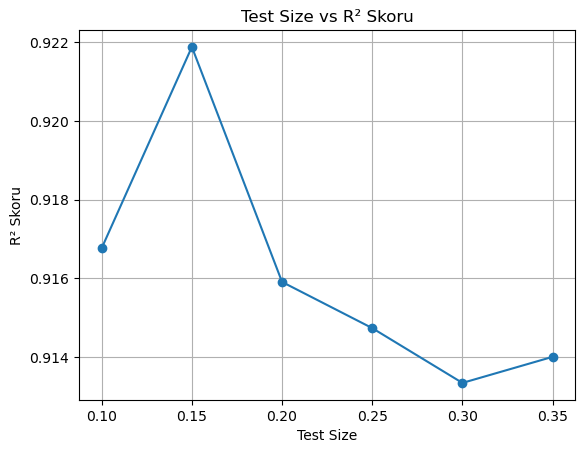

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
r2_scores = []

for size in test_sizes:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=42)

    model = RandomForestRegressor(
        n_estimators=500,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        max_depth=None,
        random_state=42
    )

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    print(f"Test size {size:.2f} => R² Skoru: {r2:.4f}")

# R² skorlarını görselleştir
plt.plot(test_sizes, r2_scores, marker='o')
plt.title("Test Size vs R² Skoru")
plt.xlabel("Test Size")
plt.ylabel("R² Skoru")
plt.grid(True)
plt.show()


In [6]:
# Train/Test yeni test_size parametresi ile
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)


### Overfitting Kontrolü

In [8]:
from sklearn.metrics import r2_score

# Eğitim seti tahmini
y_train_pred = best_model.predict(x_train)
r2_train = r2_score(y_train, y_train_pred)

# Test seti tahmini
y_test_pred = best_model.predict(x_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train R² Skoru: {r2_train:.4f}")
print(f"Test  R² Skoru: {r2_test:.4f}")


Train R² Skoru: 0.9828
Test  R² Skoru: 0.9154


In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, x, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Ortalaması: {np.mean(scores):.4f}")


Cross-Validation R² Ortalaması: 0.9126


In [10]:
importances = best_model.feature_importances_
for col, imp in zip(x.columns, importances):
    print(f"{col}: {imp:.4f}")

m2: 0.2089
total_room: 0.0147
age: 0.0491
floor: 0.0230
district_encoded: 0.0541
neighbor_encoded: 0.6502


| Değerlendirme      | R² Skoru | Yorum                                  |
| ------------------ | -------- | -------------------------------------- |
| **Train R²**       | 0.9874   | Çok yüksek, neredeyse mükemmel öğrenme |
| **Test R²**        | 0.9122   | Yüksek ve sağlam                       |
| **CV R² (5-fold)** | 0.9130   | Test skoruyla çok yakın                |


**Hiperparametre Ayarı**

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import numpy as np

# Parametre aralığı
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # 'auto' çıkarıldı!
}

# Model
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV tanımı
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Kaç farklı kombinasyon denenecek
    cv=5,       # 5-fold cross-validation
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Tüm CPU çekirdeklerini kullan
)

# Arama başlat
random_search.fit(x_train, y_train)

# En iyi modeli ve skorunu yazdır
best_model = random_search.best_estimator_
print("En iyi parametreler:", random_search.best_params_)

# Performansı değerlendir
y_test_pred = best_model.predict(x_test)
r2_test = r2_score(y_test, y_test_pred)
print(f"Tuned modelin test verisindeki R² skoru: {r2_test:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
En iyi parametreler: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Tuned modelin test verisindeki R² skoru: 0.9205


# Final

In [15]:
final_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=None,
    random_state=42
)
final_model.fit(x_train, y_train)

RandomForestRegressor(max_features='log2', n_estimators=500, random_state=42)

In [16]:
from sklearn.metrics import r2_score

# Final modeli tanımla ve eğit
final_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=None,
    random_state=42
)
final_model.fit(x_train, y_train)

# Eğitim ve test tahminleri
y_train_pred = final_model.predict(x_train)
y_test_pred = final_model.predict(x_test)

# R² skorlarını hesapla
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Sonuçları yazdır
print(f"Final Model - Train R² Skoru: {r2_train:.4f}")
print(f"Final Model - Test  R² Skoru: {r2_test:.4f}")

Final Model - Train R² Skoru: 0.9885
Final Model - Test  R² Skoru: 0.9219


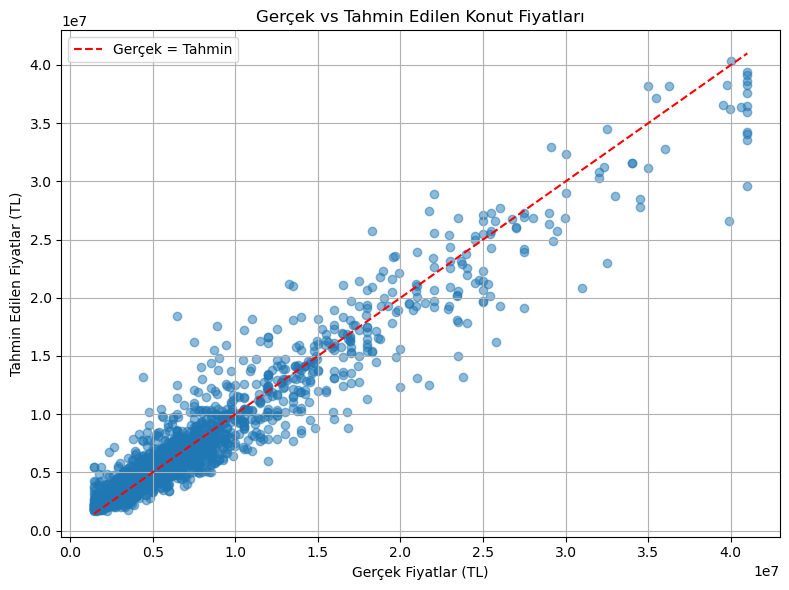

In [17]:
import matplotlib.pyplot as plt

# Test tahminlerini al
y_pred = final_model.predict(x_test)

# Grafik
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Gerçek = Tahmin')
plt.xlabel("Gerçek Fiyatlar (TL)")
plt.ylabel("Tahmin Edilen Fiyatlar (TL)")
plt.title("Gerçek vs Tahmin Edilen Konut Fiyatları")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# float olan floor değeri daha net olması için --> int
df["floor"] = df["floor"].astype(int)

In [19]:
import joblib

# Eğittiğin final modeli kaydet
joblib.dump(final_model, "konut_fiyat_modeli.joblib")

['konut_fiyat_modeli.joblib']